In [1]:
import pandas_datareader as pdr

In [2]:
key = "aa7f0f5e83dc0ab16271954612e7d89fb388da35"

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

D:\Python\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
print(df.head())

  symbol                       date   close    high     low    open    volume  \
0   AAPL  2017-08-28 00:00:00+00:00  161.47  162.00  159.93  160.14  25279674   
1   AAPL  2017-08-29 00:00:00+00:00  162.91  163.12  160.00  160.10  29307862   
2   AAPL  2017-08-30 00:00:00+00:00  163.35  163.89  162.61  163.80  26973946   
3   AAPL  2017-08-31 00:00:00+00:00  164.00  164.52  163.48  163.64  26412439   
4   AAPL  2017-09-01 00:00:00+00:00  164.05  164.94  163.63  164.80  16508568   

    adjClose    adjHigh     adjLow    adjOpen  adjVolume  divCash  splitFactor  
0  38.309297  38.435042  37.943927  37.993750  101118696      0.0          1.0  
1  38.650942  38.700765  37.960535  37.984260  117231448      0.0          1.0  
2  38.755334  38.883450  38.579766  38.862098  107895784      0.0          1.0  
3  38.909548  39.032920  38.786177  38.824137  105649756      0.0          1.0  
4  38.921411  39.132566  38.821765  39.099351   66034272      0.0          1.0  


In [8]:
print(df.tail())

     symbol                       date   close    high      low    open  \
1254   AAPL  2022-08-22 00:00:00+00:00  167.57  169.86  167.135  169.69   
1255   AAPL  2022-08-23 00:00:00+00:00  167.23  168.71  166.650  167.08   
1256   AAPL  2022-08-24 00:00:00+00:00  167.53  168.11  166.245  167.32   
1257   AAPL  2022-08-25 00:00:00+00:00  170.03  170.14  168.350  168.78   
1258   AAPL  2022-08-26 00:00:00+00:00  163.62  171.05  163.560  170.57   

        volume  adjClose  adjHigh   adjLow  adjOpen  adjVolume  divCash  \
1254  69026809    167.57   169.86  167.135   169.69   69026809      0.0   
1255  54147079    167.23   168.71  166.650   167.08   54147079      0.0   
1256  53841524    167.53   168.11  166.245   167.32   53841524      0.0   
1257  51218209    170.03   170.14  168.350   168.78   51218209      0.0   
1258  78960980    163.62   171.05  163.560   170.57   78960980      0.0   

      splitFactor  
1254          1.0  
1255          1.0  
1256          1.0  
1257          1.0 

## We are using the 'close' column to make the stock predictions as the closing value is the standard benchmark for tracking the regular trading performance.

In [9]:
df1 = df.reset_index()['close']

In [10]:
df1

0       161.47
1       162.91
2       163.35
3       164.00
4       164.05
         ...  
1254    167.57
1255    167.23
1256    167.53
1257    170.03
1258    163.62
Name: close, Length: 1259, dtype: float64

In [11]:
df1.shape

## here we can see that we are having 1257 records in the given data

(1259,)

In [12]:
import matplotlib.pyplot as plt

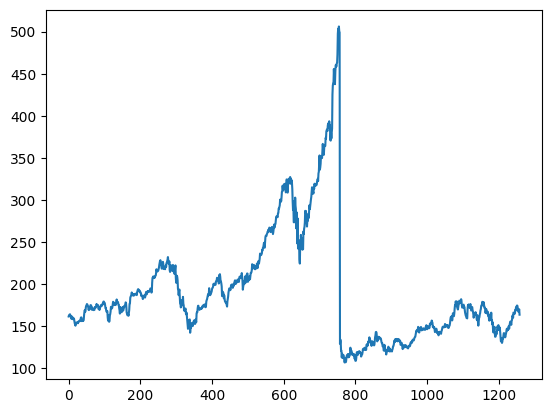

In [13]:
plt.plot(df1)

# In order to converge the data faster in LSTM we are using the MIN_MAX scaler

In [14]:
import numpy as np

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
df1

array([[0.13683156],
       [0.14043832],
       [0.14154039],
       ...,
       [0.15201002],
       [0.15827176],
       [0.14221666]])

In [17]:
df1.shape

(1259, 1)

## Splitting the dataset for the LSTM model

In [18]:
## In timeseries data one data is dependent on other data and the training data is 65 percent of the total dataset and the test dataset is the difference between the length of the data and training data

training_size = int(len(df1)*0.65)
test_size = int(len(df1)) - training_size
training_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

In [19]:
training_size, test_size

(818, 441)

In [20]:
import numpy 

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
time_step = 100
X_train, y_train = create_dataset(training_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
print(X_train.shape)

(717, 100)


In [23]:
print(y_train.shape)

(717,)


In [24]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [25]:
## reshaping the input into 3-dimension so that the input can be used for the LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
##Creating the stacked LSTM model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [48]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs = 20, batch_size = 32 , verbose = 1)

Epoch 1/20
23/23 [==============================] - 7s 144ms/step - loss: 0.0328 - val_loss: 0.0044
Epoch 2/20
23/23 [==============================] - 2s 105ms/step - loss: 0.0108 - val_loss: 3.3561e-04
Epoch 3/20
23/23 [==============================] - 2s 104ms/step - loss: 0.0091 - val_loss: 0.0015
Epoch 4/20
23/23 [==============================] - 2s 105ms/step - loss: 0.0086 - val_loss: 2.4477e-04
Epoch 5/20
23/23 [==============================] - 2s 104ms/step - loss: 0.0068 - val_loss: 9.4717e-04
Epoch 6/20
23/23 [==============================] - 2s 103ms/step - loss: 0.0055 - val_loss: 6.4431e-04
Epoch 7/20
23/23 [==============================] - 2s 109ms/step - loss: 0.0072 - val_loss: 5.9507e-04
Epoch 8/20
23/23 [==============================] - 2s 107ms/step - loss: 0.0047 - val_loss: 2.7612e-04
Epoch 9/20
23/23 [==============================] - 2s 107ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 10/20
23/23 [==============================] - 2s 105ms/step - loss: 0

In [55]:
import tensorflow as tf

In [56]:
tf.__version__

'2.9.1'

In [57]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 29ms/step


In [58]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [61]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

242.5645221203987

In [62]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

149.5051726820218

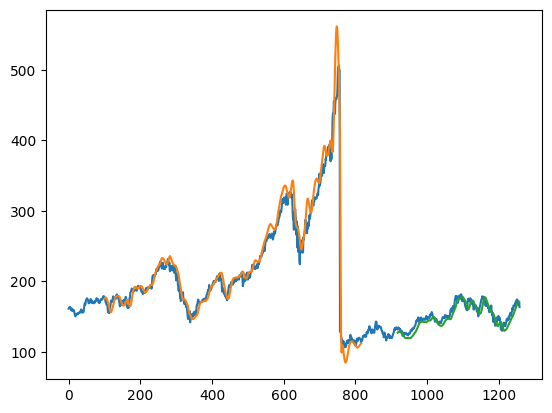

In [63]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [64]:
len(test_data)

441

In [67]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [68]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [69]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.15874904]
101
1 day input [0.16278021 0.16355667 0.15842204 0.14755166 0.15233563 0.1591985
 0.1463995  0.14584847 0.15168441 0.15125861 0.14922981 0.13763306
 0.14036318 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008
 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887
 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958
 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348
 0.107201   0.10519724 0.10487163 0.11113338 0.096531   0.09843456
 0.10487163 0.10299311 0.08966813 0.07586725 0.0627176  0.06492173
 0.07160927 0.05815905 0.06191609 0.07271133 0.07140889 0.0787226
 0.08721353 0.08721353 0.07664371 0.08112711 0.07484033 0.0803757
 0.08696306 0.09036944 0.09896055 0.10068879 0.0952536  0.09773325
 0.09680651 0.10427051 0.10852849 0.10076393 0.11060739 0.11571697
 0.12150282 0.1183469  0.11549155 0.11211021 0.12510958 0.12651221
 0.13943644 0.13693175 0.1331747  0.14850344 0.14770194 0.14654978
 0.14534753 0.14547276 0.15629305 0.

In [70]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [71]:
import matplotlib.pyplot as plt

In [72]:
len(df1)

1259

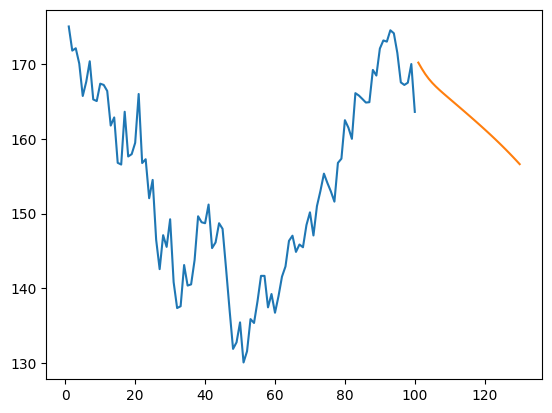

In [74]:
## taking the 100 prev data from the dataset to predict the stocks values
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

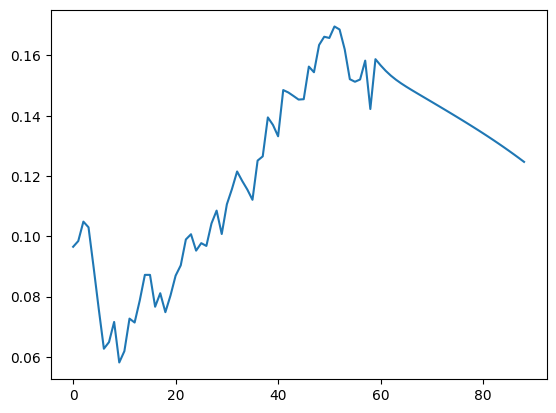

In [75]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [76]:
df3=scaler.inverse_transform(df3).tolist()

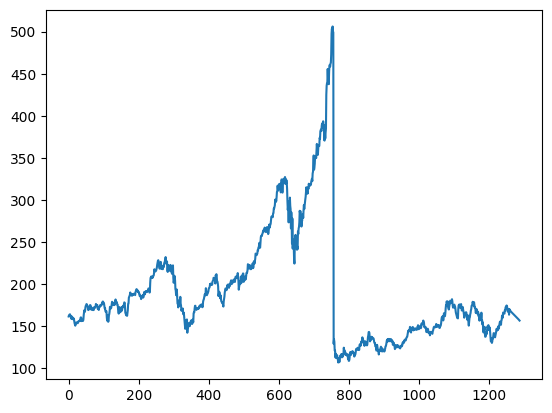

In [77]:
plt.plot(df3)